# Bayesian Analysis of Grid Congestion

Estimate the probability of grid congestion (transformer overload) based on the number of electric vehicles (EVs) and solar panels (PVs) connected to a low-voltage network.
Instead of fixed thresholds, the model provides probabilistic estimates with uncertainty bounds.

### Mathematical Model

Assuming there is no interaction between EV and PV influence (which is logical because in our model they operate during different hours, see MC notebook), we model the **log-odds of congestion** using a Bayesian logistic regression:


$$p(\text{congestion} | n_{EV}, n_{PV}) = \text{logit}^{-1}(\alpha + \beta_{EV} \cdot n_{EV} + \beta_{PV} \cdot n_{PV})$$

Where:
- $p(\text{congestion})$ is the probability of grid congestion
- $n_{EV}$ and $n_{PV}$ are standardized counts of EVs and PVs
- $\alpha$ is the intercept parameter
- $\beta_{EV}$ and $\beta_{PV}$ are effect parameters
- $\text{logit}^{-1}(x) = \frac{1}{1 + e^{-x}}$ is the inverse logit function

The model parameters have the following prior distributions:
- $\alpha \sim \mathcal{N}(0, 1)$
- $\beta_{EV} \sim \mathcal{N}(0, 1)$
- $\beta_{PV} \sim \mathcal{N}(0, 1)$
- $\sigma \sim \text{HalfNormal}(0.1)$

In [3]:
%matplotlib inline
import pymc as pm
import arviz as az
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import pickle
import sys
from matplotlib.lines import Line2D

sys.path.append("..")

## Configuration Parameters

Using Monte Carlo simulation results as an input for Bayesian analysis, therefore the  same parameters.

In [4]:
# Parameters
N_HOUSES = 50
HOURS = 24
TRANSFORMER_CAPACITY = 125  # kW
TRANSFORMER_ID = "TR_001"
DATA_DIR = "../data/generated"
PLOTS_DIR = "../data/plots"
RESULTS_FILE = f"{DATA_DIR}/monte_carlo_results.csv"
BAYESIAN_RESULTS_FILE = f"{DATA_DIR}/bayesian_results.pkl"
N_SIMULATIONS = 100
N_SAMPLES = 1000

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

## Load Monte Carlo Results

First, we load the results from the Monte Carlo simulation.

In [5]:
# Check if results file exists
if not os.path.exists(RESULTS_FILE):
    print(f"Results file {RESULTS_FILE} not found. Run monte_carlo_congestion_simulation.py first.")
    exit(1)

# Load results
results = pd.read_csv(RESULTS_FILE)
print(f"Loaded results with {len(results)} scenarios")
results.head()

Loaded results with 121 scenarios


,n_ev,n_pv,congestion_probability,avg_peak_load,max_peak_load,min_peak_load
0,0,0,0.0,110.209726,121.437710,98.048687
1,0,2,0.0,110.419142,124.004113,100.197435
2,0,4,0.0,109.661933,119.501230,101.861192
3,0,6,0.0,110.611376,118.798773,98.740977
4,0,8,0.0,110.341656,118.778754,97.879684


## Bayesian Model

We'll build a Bayesian logistic regression model to predict congestion probability based on EV and PV counts.

In [7]:
# Check if Bayesian results already exist
if os.path.exists(BAYESIAN_RESULTS_FILE):
    print(f"\nLoading existing Bayesian results from {BAYESIAN_RESULTS_FILE}")
    with open(BAYESIAN_RESULTS_FILE, "rb") as f:
        saved_results = pickle.load(f)
        idata = saved_results["idata"]
        ev_mean = saved_results["ev_mean"]
        ev_std = saved_results["ev_std"]
        pv_mean = saved_results["pv_mean"]
        pv_std = saved_results["pv_std"]
else:
    # Extract data
    n_ev = results["n_ev"].values
    n_pv = results["n_pv"].values
    congestion = results["congestion_probability"].values

    # Standardize predictors
    ev_mean, ev_std = n_ev.mean(), n_ev.std()
    pv_mean, pv_std = n_pv.mean(), n_pv.std()
    n_ev_stndrd = (n_ev - ev_mean) / ev_std
    n_pv_stndrd = (n_pv - pv_mean) / pv_std

    # Build model
    with pm.Model() as model:
        # Priors
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        beta_ev = pm.Normal("beta_ev", mu=0, sigma=1)
        beta_pv = pm.Normal("beta_pv", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=0.1)

        # Linear predictor (logit scale)
        logit_p = alpha + beta_ev * n_ev_stndrd + beta_pv * n_pv_stndrd

        # Transform to probability scale
        p = pm.Deterministic("p", pm.math.invlogit(logit_p))

        # Likelihood
        likelihood = pm.Normal("likelihood", mu=p, sigma=sigma, observed=congestion)

        # Sample posterior
        idata = pm.sample(N_SAMPLES, tune=N_SAMPLES // 4, return_inferencedata=True)

        # Save results
        print(f"Saving Bayesian results to {BAYESIAN_RESULTS_FILE}")
        saved_results = {
            "idata": idata,
            "ev_mean": ev_mean,
            "ev_std": ev_std,
            "pv_mean": pv_mean,
            "pv_std": pv_std,
        }
        with open(BAYESIAN_RESULTS_FILE, "wb") as f:
            pickle.dump(saved_results, f)


Loading existing Bayesian results from ../data/generated/bayesian_results.pkl


## Model Summary

Let's examine the posterior distributions of our model parameters.

In [8]:
# Summarize posterior
print("Bayesian Model Summary:")
az.summary(idata)

Bayesian Model Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.015,0.111,4.811,5.223,0.003,0.002,1506.0,1909.0,1.0
beta_ev,7.611,0.166,7.304,7.922,0.004,0.003,1534.0,1939.0,1.0
beta_pv,-0.031,0.023,-0.075,0.011,0.000,0.000,2426.0,2082.0,1.0
sigma,0.020,0.001,0.017,0.022,0.000,0.000,2559.0,2172.0,1.0
p[0],0.001,0.000,0.001,0.001,0.000,0.000,1716.0,2259.0,1.0
...,...,...,...,...,...,...,...,...,...
p[116],1.000,0.000,1.000,1.000,0.000,0.000,1521.0,2000.0,1.0
p[117],1.000,0.000,1.000,1.000,0.000,0.000,1534.0,1953.0,1.0
p[118],1.000,0.000,1.000,1.000,0.000,0.000,1547.0,1949.0,1.0
p[119],1.000,0.000,1.000,1.000,0.000,0.000,1559.0,2000.0,1.0


## Effect Sizes

We'll analyze the relative impact of EVs vs PVs on grid congestion.

In [9]:
# Calculate and print effect sizes
posterior = {
    "alpha": idata.posterior["alpha"].values.flatten(),
    "beta_ev": idata.posterior["beta_ev"].values.flatten(),
    "beta_pv": idata.posterior["beta_pv"].values.flatten(),
    "sigma": idata.posterior["sigma"].values.flatten(),
}

print("Effect Sizes:")
print(f"EV effect (mean): {posterior['beta_ev'].mean():.4f}")
print(f"EV effect (95% CI): [{np.percentile(posterior['beta_ev'], 2.5):.4f}, {np.percentile(posterior['beta_ev'], 97.5):.4f}]")
print(f"PV effect (mean): {posterior['beta_pv'].mean():.4f}")
print(f"PV effect (95% CI): [{np.percentile(posterior['beta_pv'], 2.5):.4f}, {np.percentile(posterior['beta_pv'], 97.5):.4f}]")

# Calculate probability that EV effect is greater than PV effect (in absolute terms)
prob_ev_greater = np.mean(np.abs(posterior["beta_ev"]) > np.abs(posterior["beta_pv"]))
print(f"Probability |EV effect| > |PV effect|: {prob_ev_greater:.4f}")

Effect Sizes:
EV effect (mean): 7.6108
EV effect (95% CI): [7.2878, 7.9432]
PV effect (mean): -0.0310
PV effect (95% CI): [-0.0751, 0.0145]
Probability |EV effect| > |PV effect|: 1.0000


## Posterior Visualization

Corner plot showing the joint distributions of model parameters (omitting the probabilities of congestion all combination of EVs and PVs). Posterior distributions look nice, no multimodalities. There is a correlation between the intercept alpha and the influence magnitude of EVs (beta_ev), which will be explored further.

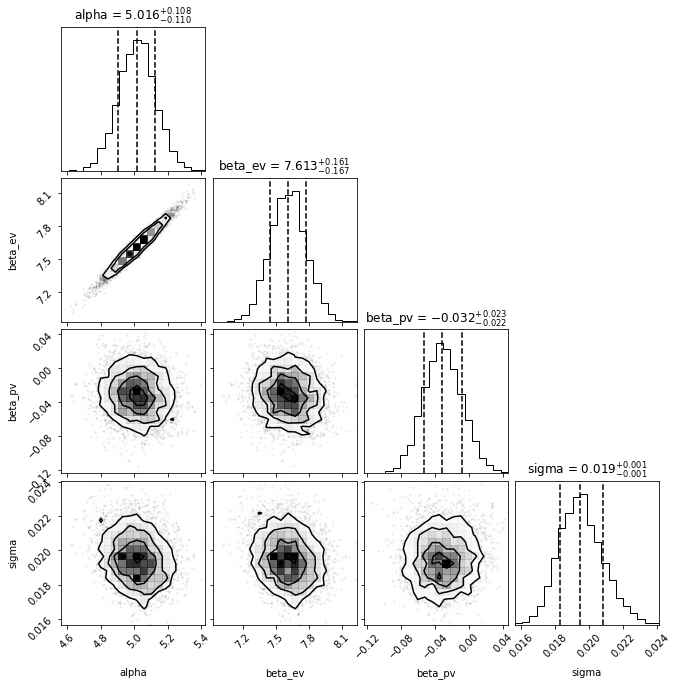

In [10]:
# Generate corner plot
corner_df = pd.DataFrame(posterior)

fig = corner.corner(
    corner_df,
    labels=["alpha", "beta_ev", "beta_pv", "sigma"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".3f",
)

plt.savefig(f"{PLOTS_DIR}/08_Bayesian_corner_plot.png")
plt.show()

## Congestion Risk Map

Contour plot showing congestion probability across different EV and PV adoption levels.

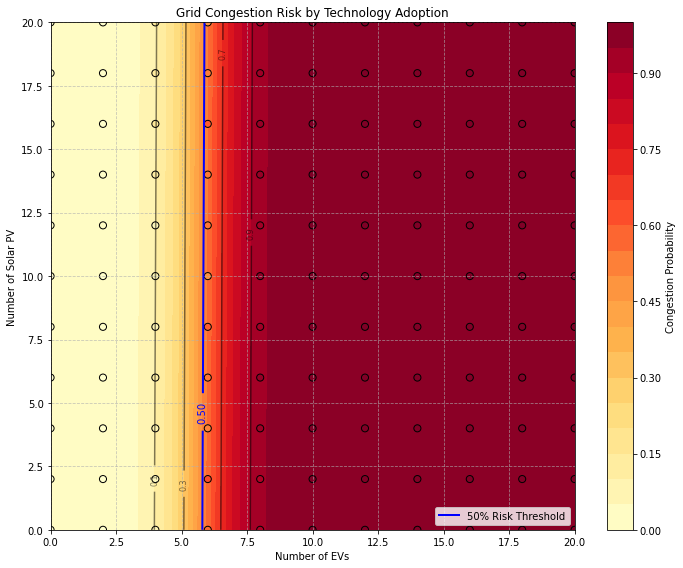

In [11]:
# Create prediction grid for smooth surface
ev_range = np.linspace(results["n_ev"].min(), results["n_ev"].max(), 100)
pv_range = np.linspace(results["n_pv"].min(), results["n_pv"].max(), 100)
ev_grid, pv_grid = np.meshgrid(ev_range, pv_range)

# Standardize grid values
ev_grid_stndrd = (ev_grid - ev_mean) / ev_std
pv_grid_stndrd = (pv_grid - pv_mean) / pv_std

# Compute predicted probabilities (mean of posterior)
logit_p = (
    posterior["alpha"].mean()
    + posterior["beta_ev"].mean() * ev_grid_stndrd
    + posterior["beta_pv"].mean() * pv_grid_stndrd
)

prob = 1 / (1 + np.exp(-logit_p))

# Create detailed contour plot with data points
plt.figure(figsize=(10, 8))
contour = plt.contourf(ev_grid, pv_grid, prob, cmap="YlOrRd", levels=20)
plt.colorbar(label="Congestion Probability")

# Add contour lines
contour_lines = plt.contour(
    ev_grid, pv_grid, prob, colors="black", alpha=0.5, levels=[0.1, 0.3, 0.7, 0.9]
)
plt.clabel(contour_lines, inline=True, fontsize=8)

# Add the 50% probability contour line in blue
contour_50 = plt.contour(
    ev_grid, pv_grid, prob, colors="blue", levels=[0.5], linewidths=2
)
plt.clabel(contour_50, inline=True, fontsize=10, fmt="%.2f")

# Add a legend entry for the 50% threshold
custom_lines = [Line2D([0], [0], color="blue", lw=2)]
plt.legend(custom_lines, ["50% Risk Threshold"], loc="lower right")

# Overlay actual data points
sc = plt.scatter(
    results["n_ev"],
    results["n_pv"],
    c=results["congestion_probability"],
    cmap="YlOrRd",
    edgecolor="black",
    s=50,
)

plt.title("Grid Congestion Risk by Technology Adoption")
plt.xlabel("Number of EVs")
plt.ylabel("Number of Solar PV")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/09_Bayesian_contour_map.png")
plt.show()

## Posterior Uncertainty Visualization

This plot shows how uncertainty in the EV effect parameter impacts predictions.

Generating logit_p vs n_ev_stndrd scatterplot with colored lines...


<ipython-input-12-95f340572497>:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


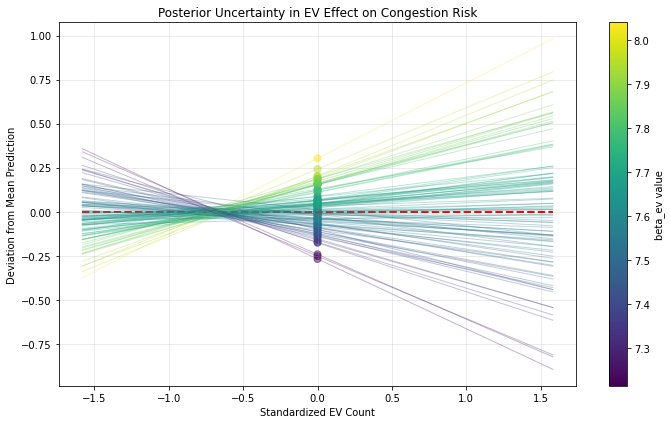

In [12]:
print("Generating logit_p vs n_ev_stndrd scatterplot with colored lines...")

n_ev = results["n_ev"].values
n_ev_stndrd = (n_ev - ev_mean) / ev_std
# Calculate logit_p using posterior means
alpha_mean = posterior["alpha"].mean()
beta_ev_mean = posterior["beta_ev"].mean()
beta_pv_mean = posterior["beta_pv"].mean()

plt.figure(figsize=(10, 6))

# Create x range for lines
x_range = np.linspace(min(n_ev_stndrd), max(n_ev_stndrd), 100)
avg_pv_std = 0  # Using standardized mean (0)

# Plot mean prediction line
y_pred_mean = alpha_mean + beta_ev_mean * x_range + beta_pv_mean * avg_pv_std
plt.plot(
    x_range, y_pred_mean - y_pred_mean, "r--", linewidth=2, label="Mean prediction"
)

# Draw multiple lines from posterior (100 random samples)
n_lines = 100
random_indices = np.random.choice(len(posterior["alpha"]), n_lines, replace=False)

# Get all beta_ev values for color mapping
all_beta_ev = posterior["beta_ev"][random_indices]
norm = plt.Normalize(all_beta_ev.min(), all_beta_ev.max())
cmap = plt.cm.viridis

for idx in random_indices:
    # Get parameter values from posterior
    a = posterior["alpha"][idx]
    b_ev = posterior["beta_ev"][idx]
    b_pv = posterior["beta_pv"][idx]

    # Calculate prediction line
    y_pred = a + b_ev * x_range + b_pv * avg_pv_std

    # Plot with color based on b_ev value
    plt.plot(
        x_range, y_pred - y_pred_mean, color=cmap(norm(b_ev)), alpha=0.3, linewidth=1
    )

plt.scatter(
    np.zeros(n_lines),
    posterior["alpha"][random_indices] - alpha_mean,
    color=cmap(norm(posterior["beta_ev"][random_indices])),
    s=50,
    alpha=0.5,
)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("beta_ev value")

plt.xlabel("Standardized EV Count")
plt.ylabel("Deviation from Mean Prediction")
plt.title("Posterior Uncertainty in EV Effect on Congestion Risk")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/10_Bayesian_logit_vs_ev_colored.png")
plt.show()